In [1]:
import pandas as pd

log_file = "/Users/alexandra/Desktop/AI_Log_PoC/loghub/Hadoop/Hadoop_2k.log"

# Read all lines from the log
with open(log_file, "r") as f:
    lines = f.readlines()

# Put lines into a DataFrame
logs = pd.DataFrame(lines, columns=["raw_line"])
logs.head(10)  # Display first 10 lines


,raw_line
0,"2015-10-18 18:01:47,978 INFO [main] org.apache..."
1,"2015-10-18 18:01:48,963 INFO [main] org.apache..."
2,"2015-10-18 18:01:48,963 INFO [main] org.apache..."
3,"2015-10-18 18:01:49,228 INFO [main] org.apache..."
4,"2015-10-18 18:01:50,353 INFO [main] org.apache..."
5,"2015-10-18 18:01:50,509 INFO [main] org.apache..."
6,"2015-10-18 18:01:50,556 INFO [main] org.apache..."
7,"2015-10-18 18:01:50,556 INFO [main] org.apache..."
8,"2015-10-18 18:01:50,556 INFO [main] org.apache..."
9,"2015-10-18 18:01:50,556 INFO [main] org.apache..."


In [2]:
import re

# Updated pattern to include thread
pattern = r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) (\w+) (\[.*?\]) (\S+) (.+)$"

def parse_line(line):
    match = re.match(pattern, line)
    if match:
        return match.groups()
    else:
        return (None, None, None, None, line)

# Apply parsing
logs[["timestamp", "level", "thread", "component", "message"]] = logs["raw_line"].apply(lambda x: pd.Series(parse_line(x)))

# Check result
logs.head(10)


,raw_line,timestamp,level,thread,component,message
0,"2015-10-18 18:01:47,978 INFO [main] org.apache...","2015-10-18 18:01:47,978",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Created MRAppMaster for application appattempt...
1,"2015-10-18 18:01:48,963 INFO [main] org.apache...","2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Executing with tokens:
2,"2015-10-18 18:01:48,963 INFO [main] org.apache...","2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,"Kind: YARN_AM_RM_TOKEN, Service: , Ident: (app..."
3,"2015-10-18 18:01:49,228 INFO [main] org.apache...","2015-10-18 18:01:49,228",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Using mapred newApiCommitter.
4,"2015-10-18 18:01:50,353 INFO [main] org.apache...","2015-10-18 18:01:50,353",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,OutputCommitter set in config null
5,"2015-10-18 18:01:50,509 INFO [main] org.apache...","2015-10-18 18:01:50,509",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,OutputCommitter is org.apache.hadoop.mapreduce...
6,"2015-10-18 18:01:50,556 INFO [main] org.apache...","2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
7,"2015-10-18 18:01:50,556 INFO [main] org.apache...","2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
8,"2015-10-18 18:01:50,556 INFO [main] org.apache...","2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
9,"2015-10-18 18:01:50,556 INFO [main] org.apache...","2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....


In [3]:
from sklearn.ensemble import IsolationForest

# Create simple features
logs["message_len"] = logs["message"].str.len()
logs["num_digits"] = logs["message"].str.count(r"\d")

features = logs[["message_len", "num_digits"]]

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
logs["anomaly_score"] = model.fit_predict(features)

# Filter anomalies
anomalies = logs[logs["anomaly_score"] == -1]

# Show anomalous logs
anomalies[["timestamp", "level", "thread", "component", "message"]].head(10)


,timestamp,level,thread,component,message
2,"2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,"Kind: YARN_AM_RM_TOKEN, Service: , Ident: (app..."
6,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
7,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
8,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
9,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
10,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
11,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
12,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
13,"2015-10-18 18:01:50,588",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
18,"2015-10-18 18:01:50,806",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....


In [1]:
import pandas as pd

# Path to your log file
log_file = "system_log.log"  # this is the file you just copied

# Load each line as a row
logs = pd.read_csv(log_file, sep="\n", header=None, names=["raw_line"])
logs.head(10)  # show the first 10 lines


ValueError: Specified \n as separator or delimiter. This forces the python engine which does not accept a line terminator. Hence it is not allowed to use the line terminator as separator.

In [2]:
# Open log file and read all lines
with open("system_log.log", "r") as f:
    lines = f.readlines()

# Create a DataFrame
import pandas as pd
logs = pd.DataFrame(lines, columns=["raw_line"])
logs.head(10)


FileNotFoundError: [Errno 2] No such file or directory: 'system_log.log'

In [4]:
from sklearn.ensemble import IsolationForest

# Create simple features
logs["message_len"] = logs["message"].str.len()
logs["num_digits"] = logs["message"].str.count(r"\d")

features = logs[["message_len", "num_digits"]]

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
logs["anomaly_score"] = model.fit_predict(features)

# Filter anomalies
anomalies = logs[logs["anomaly_score"] == -1]

# Show anomalous logs
anomalies[["timestamp", "level", "thread", "component", "message"]].head(10)


,timestamp,level,thread,component,message
2,"2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,"Kind: YARN_AM_RM_TOKEN, Service: , Ident: (app..."
6,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
7,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
8,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
9,"2015-10-18 18:01:50,556",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
10,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
11,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
12,"2015-10-18 18:01:50,572",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
13,"2015-10-18 18:01:50,588",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....
18,"2015-10-18 18:01:50,806",INFO,[main],org.apache.hadoop.yarn.event.AsyncDispatcher:,Registering class org.apache.hadoop.mapreduce....


Matplotlib is building the font cache; this may take a moment.


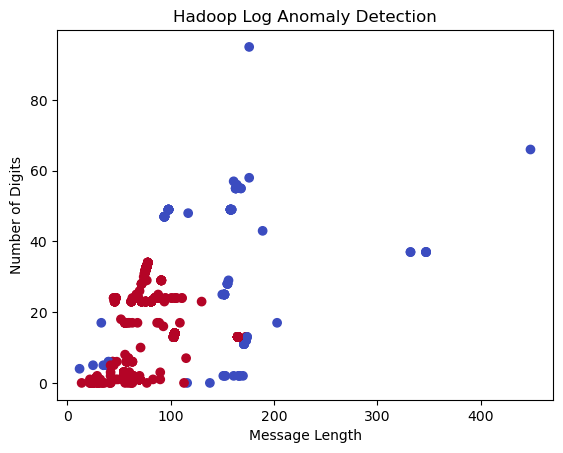

In [5]:
import matplotlib.pyplot as plt

plt.scatter(logs["message_len"], logs["num_digits"], c=logs["anomaly_score"], cmap="coolwarm")
plt.xlabel("Message Length")
plt.ylabel("Number of Digits")
plt.title("Hadoop Log Anomaly Detection")
plt.show()


In [1]:
# =========================
# PoC Phase 2: AI-assisted Log Analysis
# Using sample Hadoop logs from Loghub
# =========================

# --- Step 1: Import libraries ---
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# --- Step 2: Load structured log CSV ---
log_file = "loghub/Hadoop/Hadoop_2k.log_structured.csv"  # Update path if needed
logs = pd.read_csv(log_file)

# Quick preview
logs.head()

# --- Step 3: Prepare features for anomaly detection ---

# Convert timestamp to datetime and numeric
logs['timestamp'] = pd.to_datetime(logs['timestamp'])
logs['timestamp_num'] = logs['timestamp'].astype(int) / 10**9  # seconds since epoch

# Encode log level numerically (INFO, WARN, ERROR)
logs['level_num'] = logs['level'].astype('category').cat.codes

# Select features for model
features = logs[['timestamp_num', 'level_num']]

# --- Step 4: Run Isolation Forest ---
model = IsolationForest(contamination=0.01, random_state=42)
logs['anomaly'] = model.fit_predict(features)

# --- Step 5: Inspect anomalies ---
anomalies = logs[logs['anomaly'] == -1]
print("Top 10 anomalous log entries:")
print(anomalies.head(10))

# --- Step 6: Visualize anomalies ---
plt.figure(figsize=(12,6))
plt.scatter(logs['timestamp_num'], logs['level_num'], c=logs['anomaly'], cmap='coolwarm', s=10)
plt.xlabel("Timestamp (seconds since epoch)")
plt.ylabel("Log Level (encoded)")
plt.title("Anomaly Detection in Sample Hadoop Logs")
plt.show()

# =========================
# Notes:
# - '1' = normal log line, '-1' = anomaly
# - Later, this same approach can be applied to Genesys logs for root cause analysis.
# =========================


KeyError: 'timestamp'

In [2]:
# Check the columns in your CSV
logs.columns


Index(['LineId', 'Date', 'Time', 'Level', 'Process', 'Component', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')

/var/folders/js/ws8zykdd5j998m2nv07pmckr0000gn/T/ipykernel_82762/841123773.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])


Top 10 anomalous log entries:
Empty DataFrame
Columns: [LineId, Date, Time, Level, Process, Component, Content, EventId, EventTemplate, timestamp, timestamp_num, level_num, anomaly]
Index: []


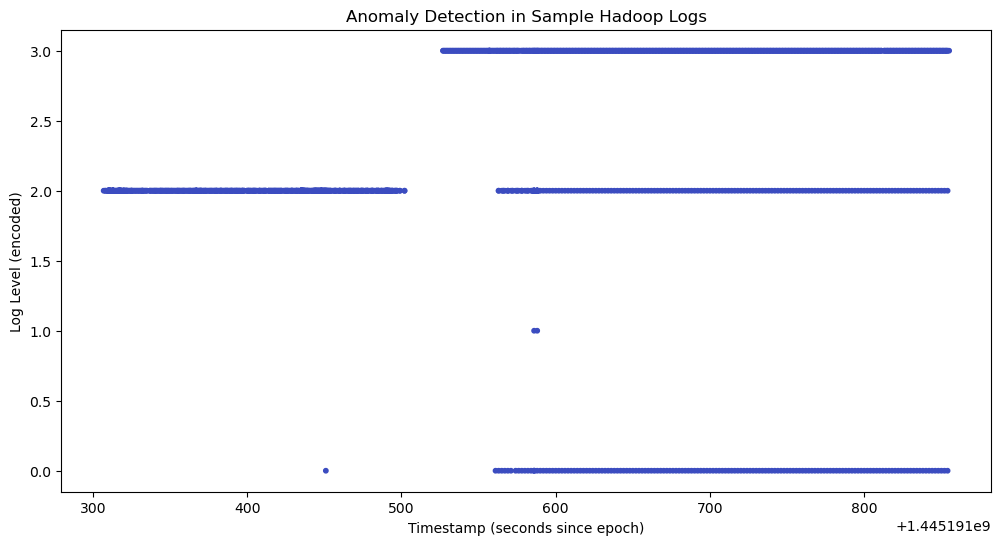

In [3]:
# Combine Date and Time into a single datetime column
logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])

# Convert to numeric for anomaly detection
logs['timestamp_num'] = logs['timestamp'].astype(int) / 10**9  # seconds since epoch

# Encode log level numerically
logs['level_num'] = logs['Level'].astype('category').cat.codes

# Select features for Isolation Forest
features = logs[['timestamp_num', 'level_num']]

# Run Isolation Forest
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.01, random_state=42)
logs['anomaly'] = model.fit_predict(features)

# Inspect anomalies
anomalies = logs[logs['anomaly'] == -1]
print("Top 10 anomalous log entries:")
print(anomalies.head(10))

# Visualize anomalies
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(logs['timestamp_num'], logs['level_num'], c=logs['anomaly'], cmap='coolwarm', s=10)
plt.xlabel("Timestamp (seconds since epoch)")
plt.ylabel("Log Level (encoded)")
plt.title("Anomaly Detection in Sample Hadoop Logs")
plt.show()


Top 10 anomalous log entries:
     LineId        Date          Time  Level                   Process  \
667     668  2015-10-18  18:04:11,034  ERROR  RMCommunicator Allocator   
922     923  2015-10-18  18:06:01,840  ERROR  RMCommunicator Allocator   
930     931  2015-10-18  18:06:03,856  ERROR  RMCommunicator Allocator   
937     938  2015-10-18  18:06:05,934  ERROR  RMCommunicator Allocator   
946     947  2015-10-18  18:06:07,950  ERROR  RMCommunicator Allocator   
955     956  2015-10-18  18:06:09,966  ERROR  RMCommunicator Allocator   
962     963  2015-10-18  18:06:11,997  ERROR  RMCommunicator Allocator   
971     972  2015-10-18  18:06:14,013  ERROR  RMCommunicator Allocator   
980     981  2015-10-18  18:06:16,029  ERROR  RMCommunicator Allocator   
987     988  2015-10-18  18:06:18,045  ERROR  RMCommunicator Allocator   

                                             Component  \
667  org.apache.hadoop.mapreduce.v2.app.rm.RMContai...   
922  org.apache.hadoop.mapreduce.v2.app

/var/folders/js/ws8zykdd5j998m2nv07pmckr0000gn/T/ipykernel_82762/1406206209.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])


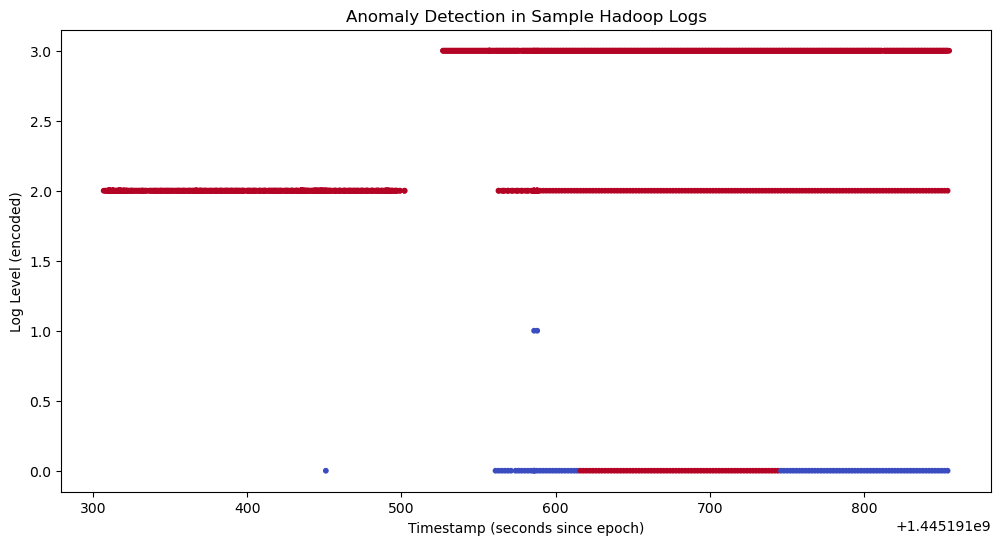

In [6]:
# Combine Date and Time into a single datetime column
logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])

# Convert to numeric for anomaly detection
logs['timestamp_num'] = logs['timestamp'].astype(int) / 10**9  # seconds since epoch

# Encode log level numerically
logs['level_num'] = logs['Level'].astype('category').cat.codes

# Select features for Isolation Forest
features = logs[['timestamp_num', 'level_num']]

# Run Isolation Forest
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.05, random_state=42)
logs['anomaly'] = model.fit_predict(features)

# Inspect anomalies
anomalies = logs[logs['anomaly'] == -1]
print("Top 10 anomalous log entries:")
print(anomalies.head(10))

# Visualize anomalies
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(logs['timestamp_num'], logs['level_num'], c=logs['anomaly'], cmap='coolwarm', s=10)
plt.xlabel("Timestamp (seconds since epoch)")
plt.ylabel("Log Level (encoded)")
plt.title("Anomaly Detection in Sample Hadoop Logs")
plt.show()

Top 10 anomalous log entries:
     LineId        Date          Time  Level                   Process  \
667     668  2015-10-18  18:04:11,034  ERROR  RMCommunicator Allocator   
922     923  2015-10-18  18:06:01,840  ERROR  RMCommunicator Allocator   
930     931  2015-10-18  18:06:03,856  ERROR  RMCommunicator Allocator   
937     938  2015-10-18  18:06:05,934  ERROR  RMCommunicator Allocator   
946     947  2015-10-18  18:06:07,950  ERROR  RMCommunicator Allocator   
955     956  2015-10-18  18:06:09,966  ERROR  RMCommunicator Allocator   
962     963  2015-10-18  18:06:11,997  ERROR  RMCommunicator Allocator   
971     972  2015-10-18  18:06:14,013  ERROR  RMCommunicator Allocator   
980     981  2015-10-18  18:06:16,029  ERROR  RMCommunicator Allocator   
987     988  2015-10-18  18:06:18,045  ERROR  RMCommunicator Allocator   

                                             Component  \
667  org.apache.hadoop.mapreduce.v2.app.rm.RMContai...   
922  org.apache.hadoop.mapreduce.v2.app

/var/folders/js/ws8zykdd5j998m2nv07pmckr0000gn/T/ipykernel_82762/355727063.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])


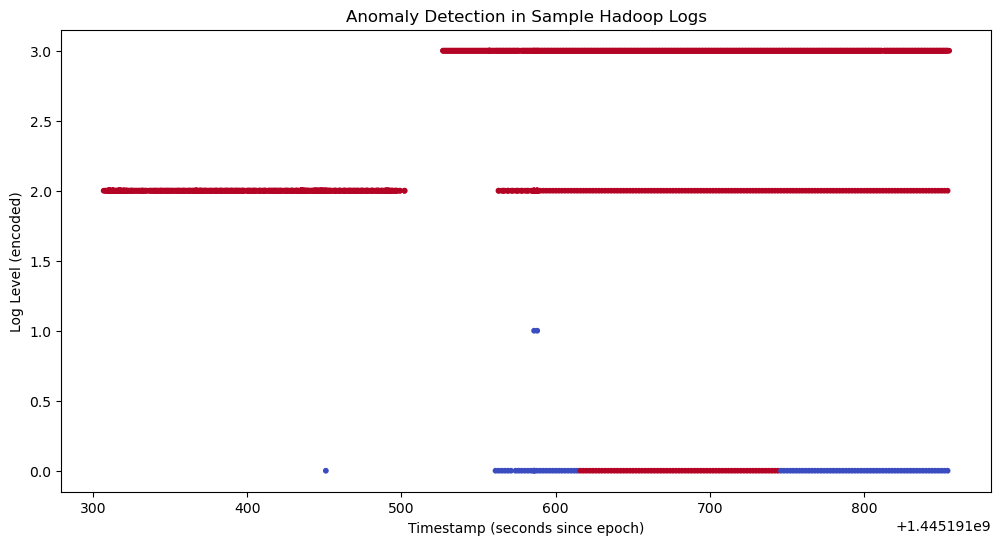

In [9]:
# Combine Date and Time into a single datetime column
logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'])

# Convert to numeric for anomaly detection
logs['timestamp_num'] = logs['timestamp'].astype(int) / 10**9  # seconds since epoch

# Encode log level numerically
logs['timestamp'] = pd.to_datetime(logs['Date'] + ' ' + logs['Time'], format='%Y-%m-%d %H:%M:%S,%f')

# Select features for Isolation Forest
features = logs[['timestamp_num', 'level_num']]

# Run Isolation Forest
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.05, random_state=42)
logs['anomaly'] = model.fit_predict(features)

# Inspect anomalies
anomalies = logs[logs['anomaly'] == -1]
print("Top 10 anomalous log entries:")
print(anomalies.head(10))

# Visualize anomalies
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(logs['timestamp_num'], logs['level_num'], c=logs['anomaly'], cmap='coolwarm', s=10)
plt.xlabel("Timestamp (seconds since epoch)")
plt.ylabel("Log Level (encoded)")
plt.title("Anomaly Detection in Sample Hadoop Logs")
plt.show()
